# **Using Isolation Trees to Identify Anomalies in HR Data**
Adam McKinnon and I decided to explore the use of isolation trees to identify anomalies in HR data. We used the IBM Attrition dataset available on the Kaggle website to demonstrate how this work can be done. 

This project is done all in Python, using the [H2O library](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/if.html#). 

## **Table of Contents**

* [Introduction & Business Problem](#introduction)
* [Data & Libraries](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results](#results)
* [Conclusion](#conclusion)

(This project was a collaboration between myself and Adam McKinnon.)

### **Introduction & Business Problem** <a name="introduction"></a>

**Business Problem**

The topic of data quality is like that of I.T. services generally… you only ever hear about it when there’s a problem! There appears a universal and implicit assumption among stakeholders receiving the findings of people analytics initiatives that your data is “good”. Failure to observe this assumption of high-quality data can significantly (and rapidly) undermine the credibility of findings, irrespective of how small the data quality deviation! 

From an analytical perspective, the quality of your insights can be potentially limited by flawed data. As the saying goes “garbage in, garbage out”. Coupled with stakeholder expectations, it becomes increasingly important that analytics practitioners invest time and energy in the assessment and curation of high-quality data to maximise the influence of analytics on decision making in their organisations. 

At the same time, monitoring data quality can be immensely time consuming, simplistic in execution (i.e., simple evaluation criteria such as age ranges), highly repetitive, and utterly devoid of ANY professional enjoyment! To overcome these shortcomings, we have developed an automated, sophisticated, multi-dimensional and scalable approach to data quality evaluation using unsupervised machine learning—Isolation Forests. 

**The Process**

We will use Isolation Forests, an unsupervised machine learning approach, to scan employee data for potentially anomalous records.  


### **Data & Libraries** <a name="data"></a>

For this project, we used the IBM HR Attrition dataset ([available on the Kaggle website](https:/https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset)). This particular set of data has 35 variables, including a mixture of quantitative and qualitative. 

There are a few options when it comes to packages that support use of the isolation forrest algorithm (our model of choice for this project - more on that later). We decided to use the H2O package because it limits the amount of data transformation that needs to be done. Alternative packages require you to one-hot-encode the data, whereas the H2O package works with a mixture of quantiative and qualitative data. 

After installing the H2O and Pandas libraries, we ingested the HR data and did some minor cleanup of column names. 



####Install h20 and import libraries

In [ ]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 177.0 MB 36 kB/s 
  Created wheel for h2o: filename=h2o-3.36.1.3-py2.py3-none-any.whl size=177103819 sha256=e847b22d540d149335e1c991b4531d4b8b4325990116f72fc8257b80bdffdcb7
  Stored in directory: /root/.cache/pip/wheels/64/86/0f/d54be71f64b85d238edb037069bc866f2156cc563bf02be527
Successfully built h2o


In [1]:
import pandas as pd
import h2o
h2o.init()

from h2o.estimators import H2OIsolationForestEstimator
from h2o.estimators import H2ORandomForestEstimator

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.341-b10, mixed mode)
  Starting server from C:\Python310\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\asus\AppData\Local\Temp\tmp2lq3tzjl
  JVM stdout: C:\Users\asus\AppData\Local\Temp\tmp2lq3tzjl\h2o_asus_started_from_python.out
  JVM stderr: C:\Users\asus\AppData\Local\Temp\tmp2lq3tzjl\h2o_asus_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Asia/Tehran
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_asus_pttiqx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.490 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


####Download data

In [2]:
#load IBM attrition data using h20
employee_data = h2o.import_file('WA_Fn-UseC_-HR-Employee-Attrition.csv')

#preview the column names to select those to be included in the analysis
employee_data.columns

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


['ÃƒÆ’Ã‚Â¯Ãƒâ€šÃ‚Â»Ãƒâ€šÃ‚Â¿Age',
 'Attrition',
 'BusinessTravel',
 'DailyRate',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EmployeeCount',
 'EmployeeNumber',
 'EnvironmentSatisfaction',
 'Gender',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'Over18',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [3]:
#rename the first column since it imported with extra characters
employee_data = employee_data.rename({'ÃƒÆ’Ã‚Â¯Ãƒâ€šÃ‚Â»Ãƒâ€šÃ‚Â¿Age': 'Age'})

#print the dataframe shape and preview the table
print(employee_data.shape)
employee_data.head()

(1471, 35)


Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
nan,Attrition,BusinessTravel,nan,Department,nan,nan,EducationField,nan,nan,nan,Gender,nan,nan,nan,JobRole,nan,MaritalStatus,nan,nan,nan,Over18,OverTime,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
41,Yes,Travel_Rarely,1102,Sales,nan,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,4,Male,79,3,1,Laboratory Technician,4,Single,3068,11864,0,Y,No,13,3,3,80,0,8,2,2,7,7,3,6
59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,3,Female,81,4,1,Laboratory Technician,1,Married,2670,9964,4,Y,Yes,20,4,1,80,3,12,3,2,1,0,0,0
30,No,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,1,11,4,Male,67,3,1,Laboratory Technician,3,Divorced,2693,13335,1,Y,No,22,4,2,80,1,1,2,3,1,0,0,0
38,No,Travel_Frequently,216,Research & Development,23,3,Life Sciences,1,12,4,Male,44,2,3,Manufacturing Director,3,Single,9526,8787,0,Y,No,21,4,2,80,0,10,2,3,9,7,1,8


### **Methodology** <a name="methodology"></a>

The Isolation Forest algorithm partitions data through a forest of decision trees. Each split of the data is made randomly and the number of splits it takes to isolate a record indicates whether the record is an anomaly. When a forest of random trees collectively produces shorter path lengths for particular samples, they are highly likely to be anomalies [(see their site for a more detailed explanation)](https://github.com/h2oai/h2o-tutorials/blob/master/tutorials/isolation-forest/interpreting_isolation-forest.ipynb). 

In the end, the Isolation Forest algorithm allows us to separate potentially anomalous data points from the rest. 


### **Analysis** <a name="analysis"></a>

####Run Isolation Trees algorithm on the data

Before running the algorithm, we will select the dataset columns we want to include in the data quality assessment. Then, we will train the isolation tree algorithm on the selected data. 

In [11]:
employee_data=employee_data.drop([0],axis=0)

In [12]:
#define the columns of data we will use in our analysis
x_var = ['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 
         'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate',
         'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'StandardHours', 
         'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
         'YearsSinceLastPromotion', 'YearsWithCurrManager']

#train the isolation trees model
isolation_model = H2OIsolationForestEstimator(model_id = 'isolation_forest.hex', seed = 1234)
training = isolation_model.train(training_frame = employee_data, x = x_var)
training

isolationforest Model Build progress: |

c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████| (done) 100%


Model Details
=============
H2OIsolationForestEstimator : Isolation Forest
Model Key: isolation_forest.hex


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          49970                  8            8            8             36            113           74.86

ModelMetricsAnomaly: isolationforest
** Reported on train data. **

Anomaly Score: 6.679190169417537
Normalized Anomaly Score: 0.17626913768267213

Scoring History: 
     timestamp            duration    number_of_trees    mean_tree_path_length    mean_anomaly_score
---  -------------------  ----------  -----------------  -----------------------  --------------------
     2022-10-09 13:46:58  0.002 sec   0.0                nan                      nan
     2022-10-09 13:46:58  0.023 sec   1.0                6.764026402640264        0.03932893289328932
     2022-10-09 13:46:58  0.038 sec   2.0                6.685924369747899        0.07851890756302521
     2022-10-09 13:46:58  0.047 sec   3.0                6.739199636198273        0.07824010914051843
     2022-10-09 13:46:58  0.055 sec   4.0                6.693820861678004        0.12247165532879818
     2022-10-09 13:46:58  0.062 sec   5.0                6.709297052154196        0.12112622826908541
     2022-10-09 13:46:58  0.069 sec   6.0                6.7159070294784575       0.11363718820861679
     2022-10-09 13:46:58  0.077 sec   7.0                6.718407839326208        0.12319657029478459
     2022-10-09 13:46:58  0.089 sec   8.0                6.715123096857791        0.11994816974408812
     2022-10-09 13:46:58  0.097 sec   9.0                6.71408190260231         0.1354348882410107
---  ---                  ---         ---                ---                      ---
     2022-10-09 13:46:58  0.426 sec   41.0               6.676890141955793        0.18147265999743134
     2022-10-09 13:46:58  0.434 sec   42.0               6.678075980079021        0.18521655940659074
     2022-10-09 13:46:58  0.440 sec   43.0               6.6756338386520655       0.17881724279437367
     2022-10-09 13:46:58  0.446 sec   44.0               6.678992027493777        0.18108142038812503
     2022-10-09 13:46:58  0.452 sec   45.0               6.681117110425072        0.17083011941514056
     2022-10-09 13:46:58  0.459 sec   46.0               6.684437902636904        0.1728078152226478
     2022-10-09 13:46:58  0.465 sec   47.0               6.681423400361879        0.1701488657158135
     2022-10-09 13:46:58  0.471 sec   48.0               6.681155375769           0.17196114565267412
     2022-10-09 13:46:58  0.480 sec   49.0               6.679359311154761        0.17653251408333373
     2022-10-09 13:46:58  0.488 sec   50.0               6.679190169417537        0.17626913768267213
[51 rows x 6 columns]


[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

Using the trained Isolation Forest model (above), we see an anamoly score of 6.69140874713062. We will use this value as the cutoff when labeling records that are likely anomalies. 

First, let's visualize the predictions using a histogram. 

isolationforest prediction progress: |███████████████████████████████████████████| (done) 100%


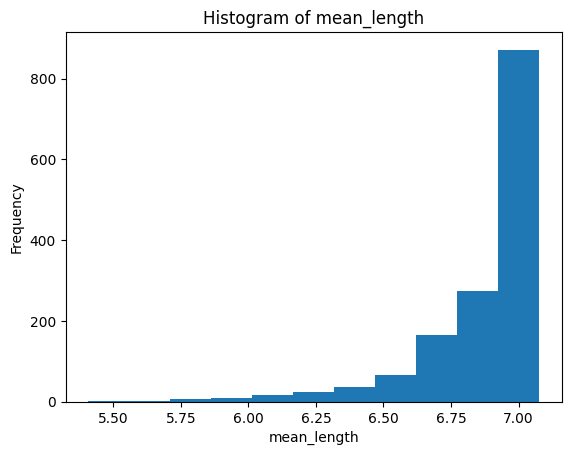

breaks,counts,mids_true,mids,widths
5.33167,nan,nan,nan,nan
5.48333,2,2.59,5.4075,0.151667
5.635,2,2.72,5.55917,0.151667
5.78667,6,2.79,5.71083,0.151667
5.93833,9,2.82,5.8625,0.151667
6.09,16,2.9,6.01417,0.151667
6.24167,23,2.97,6.16583,0.151667
6.39333,36,3.05,6.3175,0.151667
6.545,66,3.13,6.46917,0.151667
6.69667,164,3.2,6.62083,0.151667


In [13]:
#define the preductions
predictions = isolation_model.predict(employee_data)

#plot a histogram of the mean_length scores to identify the cutoff for anomalies
predictions['mean_length'].hist()

####Define the anomalies

Let's now see how many records have been identified as an anomaly using the anomaly score from the model above.

In [14]:
#print the number of anomalies identified by the model
anomalies = employee_data[predictions['mean_length'] < 6.69]
print('Number of Anomalies: ' + str(anomalies.nrow))
print('Number of Anomalies as Percent of Total: ', str(anomalies.nrow/1470))

Number of Anomalies: 598
Number of Anomalies as Percent of Total:  0.40680272108843535


In [15]:
#create a dataframe of the records identified as an anomaly from the model
anomaly_records = isolation_model.predict(anomalies)['mean_length'].cbind(anomalies[x_var])
print(anomaly_records.shape)
anomaly_records.head()

isolationforest prediction progress: |███████████████████████████████████████████| (done) 100%
(598, 31)


mean_length,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
6.44,41,Travel_Rarely,1102,Sales,nan,2,Life Sciences,2,Female,94,3,2,4,Single,5993,19479,8,Y,Yes,11,3,80,0,8,0,1,6,4,0,5
6.56,37,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,3,Single,2090,2396,6,Y,Yes,15,3,80,0,7,3,3,0,0,0,0
6.6,27,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,1,2,Married,3468,16632,9,Y,No,12,3,80,1,6,3,3,2,2,2,2
6.62,59,Travel_Rarely,1324,Research & Development,3,3,Medical,3,Female,81,4,1,1,Married,2670,9964,4,Y,Yes,20,4,80,3,12,3,2,1,0,0,0
6.68,30,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,4,Male,67,3,1,3,Divorced,2693,13335,1,Y,No,22,4,80,1,1,2,3,1,0,0,0
6.68,36,Travel_Rarely,1299,Research & Development,27,3,Medical,3,Male,94,3,2,3,Married,5237,16577,6,Y,No,13,3,80,2,17,3,2,7,7,7,7
6.5,31,Travel_Rarely,670,Research & Development,26,1,Life Sciences,1,Male,31,3,1,3,Divorced,2911,15170,1,Y,No,17,3,80,1,5,1,2,5,2,4,3
6.64,29,Travel_Rarely,1389,Research & Development,21,4,Life Sciences,2,Female,51,4,3,1,Divorced,9980,10195,1,Y,No,11,3,80,1,10,1,3,10,9,8,8
6.62,32,Travel_Rarely,334,Research & Development,5,2,Life Sciences,1,Male,80,4,1,2,Divorced,3298,15053,0,Y,Yes,12,3,80,2,7,5,2,6,2,0,5
6.4,22,Non-Travel,1123,Research & Development,16,2,Medical,4,Male,96,4,1,4,Divorced,2935,7324,1,Y,Yes,13,3,80,2,1,2,2,1,0,0,0


Next, we divide the anomalies into quartiles, allowing us to prioritize those that are most likely an anomaly over others that may be. This step is of course optional, depending on the number of anomalies identified, the standard of data quality that's needed, and the resources available to check the anomalies. 

In [16]:
#convert anomaly_records to Pandas dataframe to manipulate and calculate quartiles
anomalies_df = h2o.as_list(anomaly_records)
anomalies_df.head()

#create a column for quartiles
anomalies_df.insert(1, 'Quartile', '')

#calculate the quartile of each mean_length
anomalies_df['Quartile'] = pd.qcut(anomalies_df['mean_length'], q=4)

print("Quartile Values: ", anomalies_df['Quartile'].unique())
anomalies_df.head()

Quartile Values:  [(6.38, 6.54], (6.54, 6.62], (6.62, 6.68], (5.178999999999999, 6.38]]
Categories (4, interval[float64, right]): [(5.178999999999999, 6.38] < (6.38, 6.54] < (6.54, 6.62] < (6.62, 6.68]]


,mean_length,Quartile,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,...,PerformanceRating,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,6.44,"(6.38, 6.54]",41,Travel_Rarely,1102,Sales,NaN,2,Life Sciences,2,...,3,80,0,8,0,1,6,4,0,5
1,6.56,"(6.54, 6.62]",37,Travel_Rarely,1373,Research & Development,2.0,2,Other,4,...,3,80,0,7,3,3,0,0,0,0
2,6.60,"(6.54, 6.62]",27,Travel_Rarely,591,Research & Development,2.0,1,Medical,1,...,3,80,1,6,3,3,2,2,2,2
3,6.62,"(6.54, 6.62]",59,Travel_Rarely,1324,Research & Development,3.0,3,Medical,3,...,4,80,3,12,3,2,1,0,0,0
4,6.68,"(6.62, 6.68]",30,Travel_Rarely,1358,Research & Development,24.0,1,Life Sciences,4,...,4,80,1,1,2,3,1,0,0,0


The quartile cutoffs are below. We will use these scores later when we try to understand why these records have anomalies. 

*   1st quartile = 5.319 to 6.38
*   2nd quartile = 6.38 to 6.54
*   3rd quartile = 6.54 to 6.62
*   4th quartile = 6.62 to 6.68

Now let's see how many anomalies are in each quartile, so we can decide how many we want to evaluate further. 

In [17]:
#create a df of each quartile and print the shape of each
first = anomalies_df.loc[anomalies_df['mean_length'] < 6.38]
second = anomalies_df.loc[(anomalies_df['mean_length'] > 6.38) & (anomalies_df['mean_length'] < 6.54)]
third = anomalies_df.loc[(anomalies_df['mean_length'] > 6.54) & (anomalies_df['mean_length'] < 6.62)]
fourth = anomalies_df.loc[anomalies_df['mean_length'] > 6.62]

print('# of 1st quartile: ', first.shape)
print('# of 2nd quartile: ', second.shape)
print('# of 3rd quartile: ', third.shape)
print('# of 4th quartile: ', fourth.shape)

# of 1st quartile:  (148, 32)
# of 2nd quartile:  (127, 32)
# of 3rd quartile:  (88, 32)
# of 4th quartile:  (146, 32)


####Understand the anomalies

Now that we've broken up the anomalies into quartiles, we will train a random forrest model to predict the the variables that led each record to be flagged as an anomaly. 

We will create a loop to repeat the process ten times for each record, increasing our certainty in identify the variables that contribute to its anaomaly status. 

But first, we need to create a list of the employee numbers (unique identifier) and an empty dictionary and dataframe, which we will later populate with the output of our model. 

In [18]:
#redefine the anomalies df using the first quartile cutoff
anomalies_first = employee_data[predictions['mean_length'] < 6.38]

#copy employee data dataframe to analyize a single record previously identified as an anomaly
local_surrogate_data = employee_data[:, :]

In [24]:
#create Pandas df of anomalies table
anomalies_df = anomalies_first.as_data_frame()

#create a small test df - remove this code to run the model on the full df
anomalies_df = anomalies_df.head(5)

#create list of employees
employees = anomalies_df['EmployeeNumber'].tolist()

#create empty dictionary and df to populate with output from the model
anomalies_dict = {}
df_output = pd.DataFrame()

In [28]:
df

,C1,C2,C3,C4
0,HourlyRate,0.833333,1.000000,0.833901
1,JobSatisfaction,0.135417,0.162500,0.135509
2,YearsInCurrentRole,0.030570,0.036684,0.030591


In [25]:
#create loop to run model and extract variables with anomalies
for E in employees: 
  num = 10
  for x in range(num):
    
    #train model on anomaly record
    local_surrogate_data["anomaly_record"] = (local_surrogate_data["EmployeeNumber"] == E).ifelse("Anomaly", "NotAnomaly")

    local_surrogate_dt = H2ORandomForestEstimator(model_id = "local_level_surrogate_decision_tree.hex", 
                                                ntrees = 1, max_depth = 4,
                                                sample_rate = 1)
    local_surrogate_dt.train(training_frame = local_surrogate_data, x = x_var, y = "anomaly_record")

    #isolate variables with importance and create a frame
    local_table = local_surrogate_dt.varimp()
    frame = h2o.H2OFrame(local_table, header=-1)

    #convert frame to Pandas df to manipulate and populate dictionary
    df = frame.as_data_frame()
    df = df[df.C4 != 0]

    #calculate C4 - C2 to identify variables that need to be checked
    diff = (df['C4'].sum()) - (df['C2'].sum())

    #add values to dictionary and append to df 
    cols = df['C1'].tolist()
    anomalies_dict = {'EmployeeNumber': E, 'Variables': cols, 'Result': diff}
    df_output = df_output.append(anomalies_dict, ignore_index=True)

    print('Employee completed: ', E)

#drop rows where the result is >0.001
df_output = df_output[df_output.Result < 0.001]

#drop Result column
df_output = df_output.drop('Result', 1)

drf Model Build progress: |

c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  30
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  30
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  30
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  30
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  30
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  30
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  30
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  30
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  30
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  30
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  33
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  33
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  33
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  33
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  33
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  33


C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  33
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  33
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  33
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  33
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  36
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  36
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  36
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  36
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  36
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  36
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  36
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  36
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  36
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  36
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  58
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  58
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  58
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  58
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  58
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  58
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  58
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  58
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  58
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  58
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  73
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  73
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  73
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  73
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  73


C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)


drf Model Build progress: |

c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  73


C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)


drf Model Build progress: |

c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  73


C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  73


C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)


drf Model Build progress: |

c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  73
drf Model Build progress: |

C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [StandardHours, Over18]
  warnings.warn(mesg["message"], RuntimeWarning)
c:\Python310\lib\site-packages\h2o\estimators\estimator_base.py:193: RuntimeWarning: Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Employee completed:  73


C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_output = df_output.append(anomalies_dict, ignore_index=True)
C:\Users\asus\AppData\Local\Temp\ipykernel_21752\4143631131.py:36: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_output = df_output.drop('Result', 1)


We now have a Pandas df of the employee number and variables that were flagged as anomalous by the model. Let's now group the variables by employee number and only keep those that came up more than once. 

In [27]:
local_surrogate_data

Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,anomaly_record
41,Yes,Travel_Rarely,1102,Sales,nan,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5,NotAnomaly
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7,NotAnomaly
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0,NotAnomaly
33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0,NotAnomaly
27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2,NotAnomaly
32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,4,Male,79,3,1,Laboratory Technician,4,Single,3068,11864,0,Y,No,13,3,3,80,0,8,2,2,7,7,3,6,NotAnomaly
59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,3,Female,81,4,1,Laboratory Technician,1,Married,2670,9964,4,Y,Yes,20,4,1,80,3,12,3,2,1,0,0,0,NotAnomaly
30,No,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,1,11,4,Male,67,3,1,Laboratory Technician,3,Divorced,2693,13335,1,Y,No,22,4,2,80,1,1,2,3,1,0,0,0,NotAnomaly
38,No,Travel_Frequently,216,Research & Development,23,3,Life Sciences,1,12,4,Male,44,2,3,Manufacturing Director,3,Single,9526,8787,0,Y,No,21,4,2,80,0,10,2,3,9,7,1,8,NotAnomaly
36,No,Travel_Rarely,1299,Research & Development,27,3,Medical,1,13,3,Male,94,3,2,Healthcare Representative,3,Married,5237,16577,6,Y,No,13,3,2,80,2,17,3,2,7,7,7,7,NotAnomaly


In [26]:
#explode lists into rows for each row
df_final = df_output.explode('Variables')

#group the df by employee number and count the number of times the variable comes up
df_final = df_final.groupby(['EmployeeNumber', 'Variables']).size().reset_index(name='Count')

#sort by employee number then by count (descending)
df_final = df_final.sort_values(['EmployeeNumber', 'Count'], ascending = [True, False ])

#drop rows where count < 2
df_final = df_final[df_final.Count > 1]

#group by EmployeeNumber and create list of variables, in rank order by highest frequency to lowest
df_final = df_final.groupby('EmployeeNumber')['Variables'].apply(list).reset_index()


df_final.head(20)

,EmployeeNumber,Variables
0,30,"[TrainingTimesLastYear, MonthlyIncome, DailyRa..."
1,33,"[JobInvolvement, MonthlyRate, JobSatisfaction,..."
2,36,"[MonthlyRate, YearsWithCurrManager, Age, Hourl..."
3,58,"[EducationField, YearsAtCompany, YearsInCurren..."
4,73,"[Age, TrainingTimesLastYear, YearsInCurrentRol..."


### **Results** <a name="results"></a>

The output from our model has created a Pandas Dataframe with two fields: 

1. A unique identifier, in our case the employee number from the original dataset, which is critical to enabling identification and access to the original record that needs changing. 

2. A list of variables contributing to each records anomaly status, ranked from most important to least. 

This dataframe can now be saved as a csv to be shared with those that will be responsible for checking the employee records and updating the records as needed. 

### **Conclusion** <a name="conclusion"></a>

Unsupervised Machine Learning algorithms such as Isolation Forests can be an excellent way of automating and scaling the review of data to monitor for quality concerns. 

The major advantage of this approach is that the Isolation Forest can identify a record as anomalous, despite no one variable in the record being out of acceptable limits. Instead, the algorithm assesses the combination of multiple variables to determine if the combination makes it seem anomalous. This is like having human intelligence review each record quickly, at scale, and without destroying anyone’s job satisfaction! 

We propose that this approach has the potential to significantly reduce time spent on direct data quality evaluations, which has considerable direct benefits (i.e., better quality data, more representative analyses and interpretation, etc.) as well as indirect benefits (i.e., time can be spent on other value-add initiatives). This is particularly true for smaller teams.